# 0.0. IMPORTS

In [92]:
import inflection

import pandas  as pd
import numpy   as np
import seaborn as sns

from matplotlib import pyplot as plt

## 0.1. Load and Merge datasets

In [93]:
df_produtos = pd.read_csv( "datasets/produtos.csv" )
df_vendas   = pd.read_csv( "datasets/vendas.csv" )

df = pd.merge( df_vendas, df_produtos, how="left", on="ID_PRODUTO")

# 1.0. DATA DESCRIPTION

In [94]:
df1 = df.copy()

## 1.1. Columns Description

In [95]:
df1.columns

Index(['DATA', 'ID_PRODUTO', 'VALOR_VENDA', 'FAIXA_HORARIO', 'NOME_PRODUTO',
       'PREÇO_KG', 'PESO_MEDIO_UNITARIO_KG'],
      dtype='object')

- **DATA**: Data em que a venda foi efetuada;

- **FAIXA_HORARIO**: Faixa de horário em que a venda foi efetuada;

- **ID_PRODUTO**: Chave única que identifica um produto;

- **PESO_MEDIO_UNITARIO_KG**: Peso médio do produto medido em kilogramas;

- **PREÇO_KG**: Preço médio pago por kg;

- **NOME_PRODUTO**: Nome do produto;

- **VALOR_VENDA**: Valor total da venda para um determinado produto.

### 1.1.1. Rename columns to snakecase

In [96]:
cols = ['DATA', 'ID_PRODUTO', 'VALOR_VENDA', 'FAIXA_HORARIO', 'NOME_PRODUTO',
       'PREÇO_KG', 'PESO_MEDIO_UNITARIO_KG']

# camelcase cols to snakecase
snakecase = lambda x: inflection.underscore( x )
new_cols = list( map( snakecase , cols ) )
new_cols

# renaming cols
df1.columns = new_cols

# removing "ç" in "preço_kg"
df1 = df1.rename(columns={'preço_kg': 'preco_kg'})

## 1.2. Data Dimensions

In [97]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 9806
Number of columns: 7


## 1.3. Data Types

In [98]:
df1.dtypes

data                      object
id_produto                 int64
valor_venda               object
faixa_horario             object
nome_produto              object
preco_kg                  object
peso_medio_unitario_kg    object
dtype: object

### 1.3.1. Change data types

In [99]:
# data
df1['data'] = pd.to_datetime( df1['data'] )

# valor_venda
df1['valor_venda'] = df1['valor_venda'].apply( lambda x: x.replace( ',', '.' ) )
df1['valor_venda'] = df1['valor_venda'].astype( float )

# preco_kg
df1['preco_kg'] = df1['preco_kg'].apply( lambda x: x.replace( ',', '.' ) )
df1['preco_kg'] = df1['preco_kg'].astype( float )

# peso_medio_unitario_kg
df1['peso_medio_unitario_kg'] = df1['peso_medio_unitario_kg'].apply( lambda x: x.replace( ',', '.' ) )
df1['peso_medio_unitario_kg'] = df1['peso_medio_unitario_kg'].astype( float )

## 1.4. NA Check

In [100]:
df1.isna().sum()

data                      0
id_produto                0
valor_venda               0
faixa_horario             0
nome_produto              0
preco_kg                  0
peso_medio_unitario_kg    0
dtype: int64

### 1.4.1. NA Fullfill

No need

## 1.5.Descriptive Statistics

In [101]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# numeric attributes
df_num = df1[['valor_venda','preco_kg','peso_medio_unitario_kg']]

# central tendency - mean, median
ct1 = pd.DataFrame( df_num.apply( np.mean ) ).T
ct2 = pd.DataFrame( df_num.apply( np.median ) ).T

# dispersion metrics - std, max, min, range
dm1 = pd.DataFrame( df_num.apply( np.std ) ).T
dm2 = pd.DataFrame( df_num.apply( np.min ) ).T
dm3 = pd.DataFrame( df_num.apply( np.max ) ).T
dm4 = pd.DataFrame( df_num.apply( lambda x: x.max() - x.min() ) ).T                    

# concat
metrics = pd.concat( [dm2, dm3, dm4, ct1, ct2, dm1 ] ).T
metrics.columns = [ 'min','max','range','mean','median','std' ]
metrics

,min,max,range,mean,median,std
valor_venda,1.50,35.95,34.45,16.36,16.32,8.59
preco_kg,1.30,31.42,30.12,10.29,4.79,9.40
peso_medio_unitario_kg,0.04,1.44,1.41,0.37,0.15,0.39


# 2.0. FEATURE ENGINEERING

In [102]:
df2 = df1.copy()

In [103]:
# semana do ano
df2['semana_do_ano'] = df2['data'].dt.isocalendar().week

# quantidade de kg vendido na transação
df2['kg_vendido'] = df2['valor_venda'] /  df2['preco_kg']

# 3.0. EXPLORATORY DATA ANALYSIS

In [104]:
df3 = df2.copy()

## 1. Como está a evolução do meu faturamento em geral (todos os produtos)?

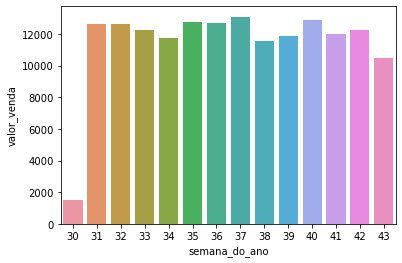

In [105]:
aux = df3[['semana_do_ano','valor_venda']].groupby( 'semana_do_ano' ).sum().reset_index()
sns.barplot( x='semana_do_ano', y='valor_venda', data=aux );

In [107]:
aux['valor_venda'].median()

12267.605

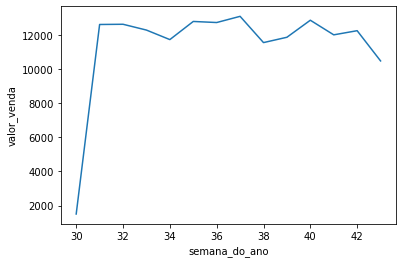

In [83]:
sns.lineplot( x='semana_do_ano', y='valor_venda', data=aux );

## 2. Qual foi o meu melhor dia em vendas?


In [84]:
aux = df3[['data','valor_venda']].groupby( 'data' ).sum().reset_index()
aux.sort_values( 'valor_venda', ascending=False ).head()

,data,valor_venda
86,2021-10-26,2365.34
14,2021-08-15,2222.69
88,2021-10-28,2222.08
89,2021-10-29,2196.56
69,2021-10-09,2159.19


O melhor dia em vendas foi **26-10-2021**. O pico pode ser observado também no gráfico abaixo:

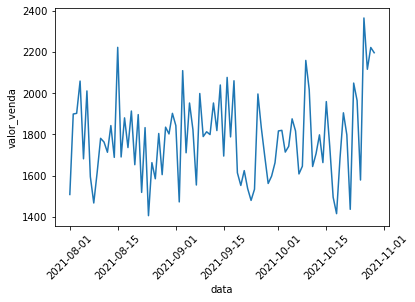

In [85]:
sns.lineplot( x='data', y='valor_venda', data=aux );
plt.xticks( rotation=45 );

## 3. Qual foi o dia em que eu mais vendi Bananas?

In [86]:
aux = df3[['data','nome_produto','kg_vendido']].groupby(['data','nome_produto']).sum().reset_index()
aux = aux[aux['nome_produto'] == 'Banana'].reset_index()
aux.sort_values( 'kg_vendido', ascending=False ).head()

,index,data,nome_produto,kg_vendido
88,1226,2021-10-28,Banana,60.90
87,1212,2021-10-27,Banana,51.41
15,210,2021-08-16,Banana,49.45
14,196,2021-08-15,Banana,49.11
86,1198,2021-10-26,Banana,48.91


O dia em que foram vendidas mais bananas foi **28-10-2021**.

## 4. Qual produto eu vendo em maior quantidade (kg)?

In [90]:
aux = df3[['nome_produto','kg_vendido']].groupby( 'nome_produto' ).sum().reset_index()
aux.sort_values( 'kg_vendido', ascending=False ).head()

,nome_produto,kg_vendido
6,Laranja,8009.02
12,Tangerina,5842.42
7,Limão,5797.62
8,Mamão,3252.48
9,Maçã,3192.76


O produto vendido em maior quantidade é a **laranja**, seguida da **tangerina** e do **limão**.

## 5. Quais estratégias você sugeriria para um faturamento maior?

- Aplicação de algoritmos de regressão na base de dados para prever as vendas das próximas semanas. O objetivo é ter o faturamento previsto em mãos pra planejar um budget de invesimento em novos produtos. Ex: salgados, sucos, verduras, legumes. A estratégia seria pesquisar pelos produtos mais vendidos na feira e trazer esses para o nosso negócio.